### Imports

In [31]:
import numpy as np
import torch
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

### Creating Simple Graph

In [37]:
H = nx.DiGraph()

In [38]:
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),
  (1, {"color": "yellow", "size": 400}),
  (2, {"color": "orange", "size": 150}),
  (3, {"color": "red", "size": 600})
])

In [39]:
for node in H.nodes(data=True):
  print(node)

(0, {'color': 'blue', 'size': 250})
(1, {'color': 'yellow', 'size': 400})
(2, {'color': 'orange', 'size': 150})
(3, {'color': 'red', 'size': 600})


In [40]:
H.add_edges_from([
  (0, 1),
  (1, 2),
  (1, 0),
  (1, 3),
  (2, 3),
  (3,0)
])

In [41]:
H.nodes()

NodeView((0, 1, 2, 3))

In [42]:
H.edges()

OutEdgeView([(0, 1), (1, 2), (1, 0), (1, 3), (2, 3), (3, 0)])

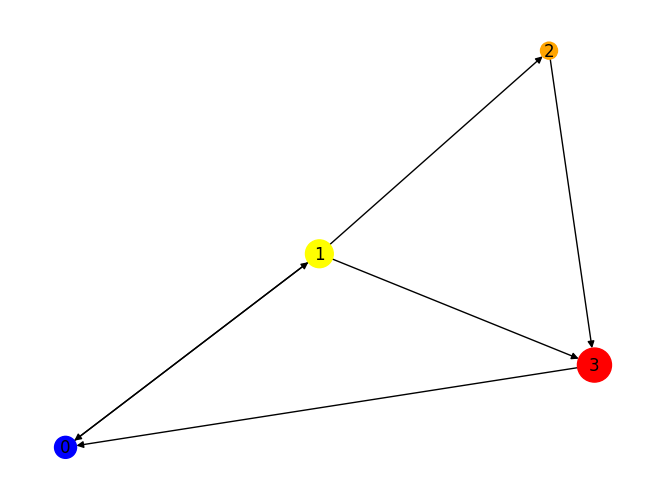

In [43]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)

node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

In [44]:
G = H.to_undirected()
print(G.edges())

[(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)]


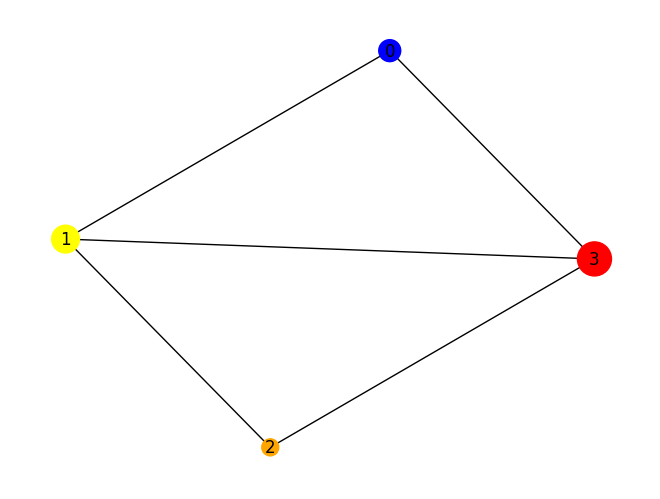

In [45]:
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

### Dataset Introduction


In [10]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print('Dataset: ', dataset)
print('\nNumber of graphs: ', len(dataset))
data = dataset[0]
print()
print(data)

Dataset:  Cora()

Number of graphs:  1

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [15]:
print('Number of features: ', dataset.num_features)
print('Number of classes: ', dataset.num_classes)

print("Number of nodes: ", data.num_nodes)
print("Number of edges: ", data.num_edges)

print('Number of training nodes: ', data.train_mask.sum())


Number of features:  1433
Number of classes:  7
Number of nodes:  2708
Number of edges:  10556
Number of training nodes:  tensor(140)


In [13]:
print("has_isolated_nodes: ", data.has_isolated_nodes())
print("has_self_loops: ", data.has_self_loops())
print("is_undirected: ", data.is_undirected())

has_isolated_nodes:  False
has_self_loops:  False
is_undirected:  True


In [22]:
# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [23]:
# Labels
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [30]:
# Example for the edge connections
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [17]:
edge_index = data.edge_index
print(type(edge_index))

<class 'torch.Tensor'>


In [18]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
print(edge_index)

(2, 10556)
[[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]


In [19]:
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

### Graph Neural Network for Node Clasification

In [33]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [34]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x


In [35]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


### Visualizing Untrained GCN network
7-dimensional node embeddings onto a 2D plane.



In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [37]:
model = GCN(hidden_channels=16)
model.eval()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)

/home/abdulrehman/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/abdulrehman/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


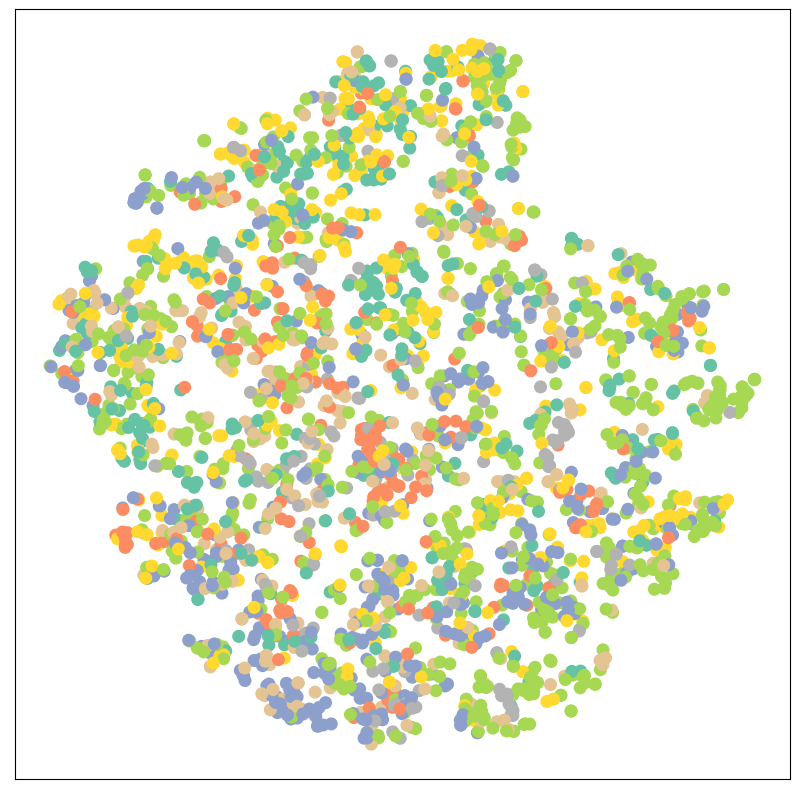

In [38]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Training and Evaluation

In [39]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)

# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()


In [40]:
def train():
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss


In [41]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc


In [42]:
losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8616
Epoch: 200, Loss: 1.7218
Epoch: 300, Loss: 1.6939
Epoch: 400, Loss: 1.6404
Epoch: 500, Loss: 1.5353
Epoch: 600, Loss: 1.4875
Epoch: 700, Loss: 1.4570
Epoch: 800, Loss: 1.3919
Epoch: 900, Loss: 1.3828
Epoch: 1000, Loss: 1.3424


In [43]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7400


### Visualizing trained GCN network

/home/abdulrehman/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/abdulrehman/anaconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


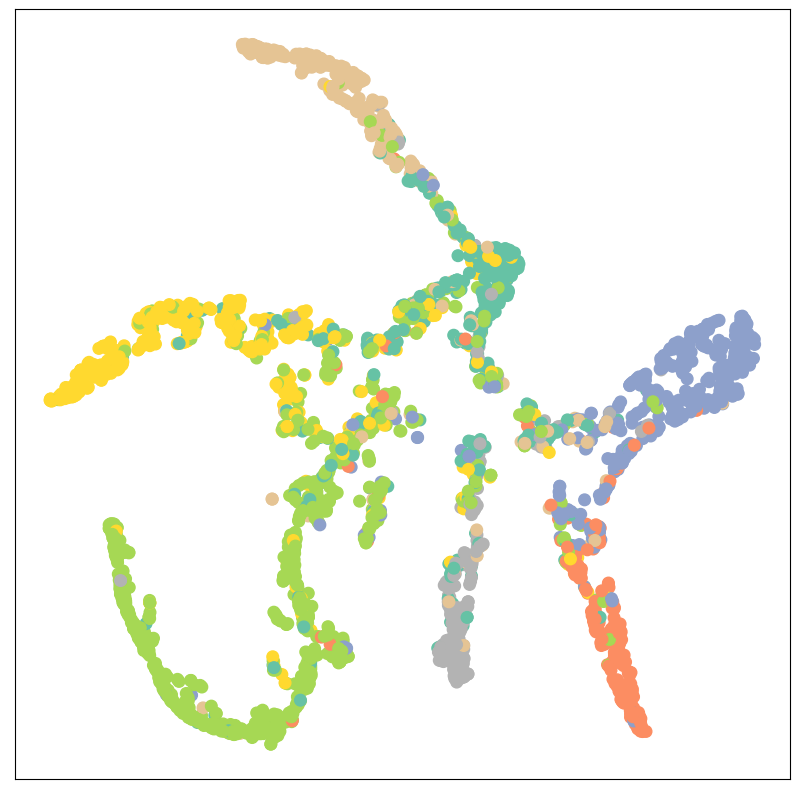

In [44]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Improving the model
- Cross-Validation
- Hyperparameter Optimization
- Different layer types GCN, GAT... ([here](hhttps://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html))
- Including edge features ([here](https://wiki.tum.de/display/dlma/Exploiting+Edge+Features+in+Graph+Neural+Networks))  
--> The best performance is currently [at around 0.9](https://paperswithcode.com/sota/node-classification-on-cora)
